In [2]:
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

from ch05.ch05 import loadings

In [3]:
df_wine = pd.read_csv('wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [12]:
##PCA步骤
#1.标准化d维数据 2.构造协方差矩阵 3.计算协方差矩阵发特征值和特征向量 4.按降序对特征值进行排序，从而对特征向量进行排序
#5.选择k（k≤d）个最大的特征值对应的特征向量，其中k是新特征子空间的维数 6.用k个特征向量构造一个投影矩阵W
#7.使用投影矩阵W对d维输入数据集X进行变换，获得新的k维特征子空间
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

[[ 0.71225893  2.22048673 -0.13025864 ... -0.20017028 -0.82164144
  -0.62946362]
 [ 0.88229214 -0.70457155  1.17533605 ...  1.33982592  0.54931269
   1.47568796]
 [ 0.84585645 -0.73022996  1.17533605 ...  1.06806189  0.1308109
   1.62934866]
 ...
 [ 1.02803489  2.29746195 -0.5778911  ... -1.69487249 -1.86068037
  -1.04434751]
 [-1.30384913 -1.08089484 -0.31677217 ...  0.16218176  0.73691694
   0.40313628]
 [-0.40510216  1.29678411  0.05625489 ...  1.06806189  0.73691694
  -0.89683324]]


In [ ]:
# ---
# 
# **Note**
# 应当使用训练集的参数来进行测试集的处理，所以上段代码中X_train_std = sc.fit_transform(X_train)要进行fit，而X_test_std = sc.transform(X_test)中没有
# Accidentally, I wrote `X_test_std = sc.fit_transform(X_test)` instead of `X_test_std = sc.transform(X_test)`. In this case, it wouldn't make a big difference since the mean and standard deviation of the test set should be (quite) similar 
# to the training set. However, as remember from Chapter 3, the correct way is to re-use parameters from the training set if we are doing any kind of transformation -- the test set should basically stand for "new, unseen" data.
# 
# My initial typo reflects a common mistake is that some people are *not* re-using these parameters from the model training/building and standardize the new data "from scratch." Here's simple example to explain why this is a problem.
# 
# Let's assume we have a simple training set consisting of 3 examples with 1 feature (let's call this feature "length"):
# 
# - train_1: 10 cm -> class_2
# - train_2: 20 cm -> class_2
# - train_3: 30 cm -> class_1
# 
# mean: 20, std.: 8.2
# 
# After standardization, the transformed feature values are
# 
# - train_std_1: -1.21 -> class_2
# - train_std_2: 0 -> class_2
# - train_std_3: 1.21 -> class_1
# 
# Next, let's assume our model has learned to classify examples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:
# 
# - new_4: 5 cm -> class ?
# - new_5: 6 cm -> class ?
# - new_6: 7 cm -> class ?
# 
# If we look at the "unstandardized "length" values in our training datast, it is intuitive to say that all of these examples are likely belonging to class_2. However, if we standardize these by re-computing standard deviation  and 
# mean you would get similar values as before in the training set and your classifier would (probably incorrectly) classify examples 4 and 5 as class 2.
# 
# - new_std_4: -1.21 -> class 2
# - new_std_5: 0 -> class 2
# - new_std_6: 1.21 -> class 1
# 
# However, if we use the parameters from your "training set standardization," we'd get the values:
# 
# - example5: -18.37 -> class 2
# - example6: -17.15 -> class 2
# - example7: -15.92 -> class 2
# 
# The values 5 cm, 6 cm, and 7 cm are much lower than anything we have seen in the training set previously. Thus, it only makes sense that the standardized features of the "new examples" are much lower than every standardized feature in the training set.
# 
# ---

In [15]:
# Eigendecomposition of the covariance matrix.
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n', eigen_vals)


Eigenvalues 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


[0.3695146859960761, 0.1843492705988418, 0.11815159094597, 0.0733425176378547, 0.06422107821731672, 0.05051724484907655, 0.03954653891241444, 0.02643918316922002, 0.02389319259185292, 0.016296137737251006, 0.013800211221948423, 0.01172226244308597, 0.00820608567909137]


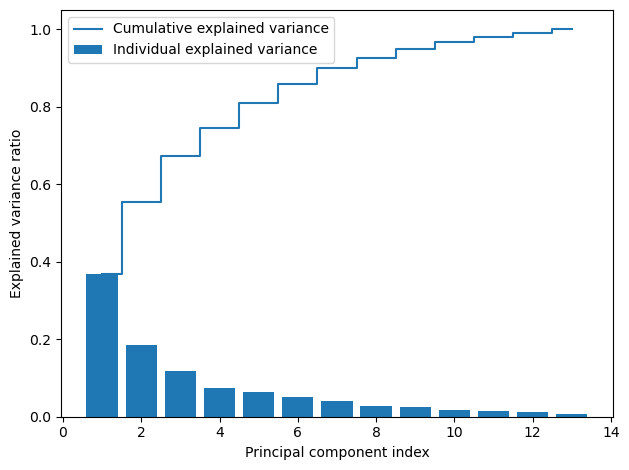

In [17]:
# **Note**: 
# 
# Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
#     <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
#     This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for 
#     [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that 
#     it returns complex eigenvalues in certain cases. (S.R.)
# 

# ## Total and explained variance

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 14), var_exp, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [20]:
# ## Feature transformation     特征变换
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])for i in range(len(eigen_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

#得到投影矩阵w
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


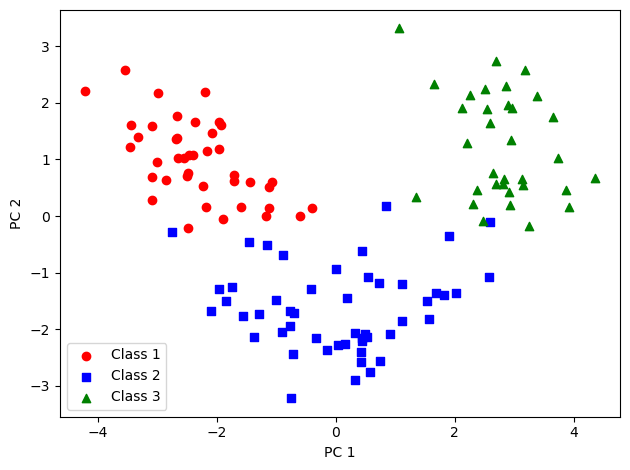

In [21]:
#使用投影矩阵将样本x变换到PCA子空间
X_train_std[0].dot(w)
#将整个训练集变换到PCA子空间
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

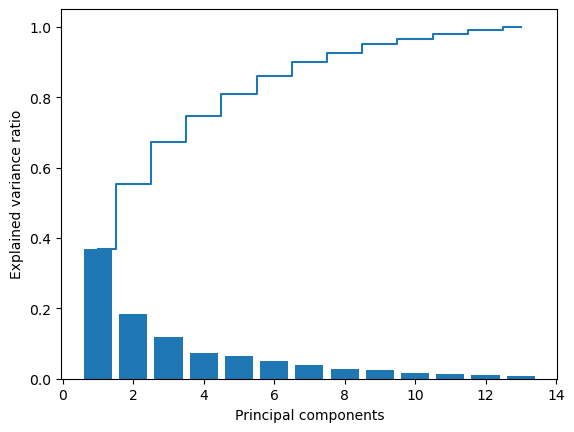

In [22]:
#使用scikit-learn实现主成分分析
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

plt.bar(range(1, 14), pca.explained_variance_ratio_, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

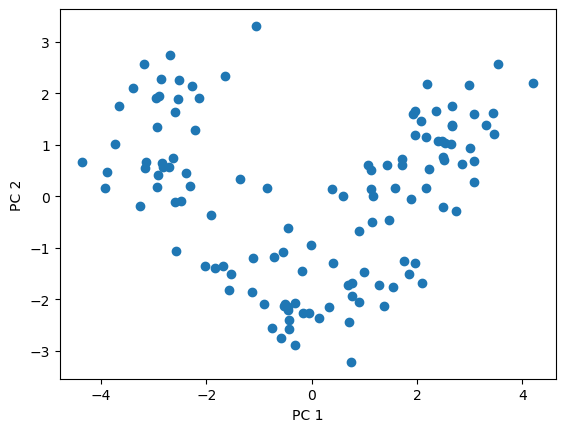

In [23]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [24]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')


# Training logistic regression classifier using the first 2 principal components.

D:\software\Anaconda\envs\pytorchStudy\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


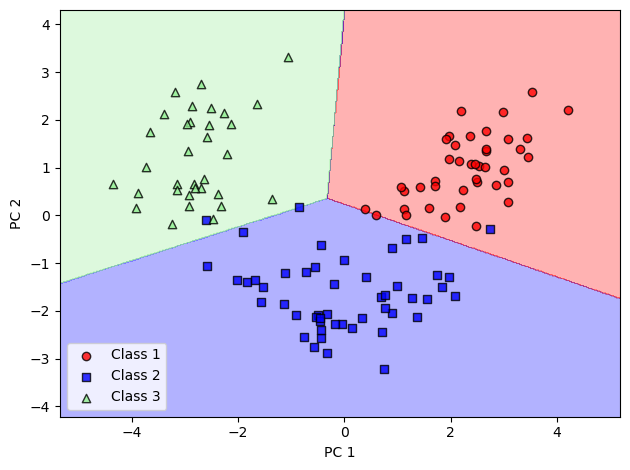

In [25]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

D:\software\Anaconda\envs\pytorchStudy\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


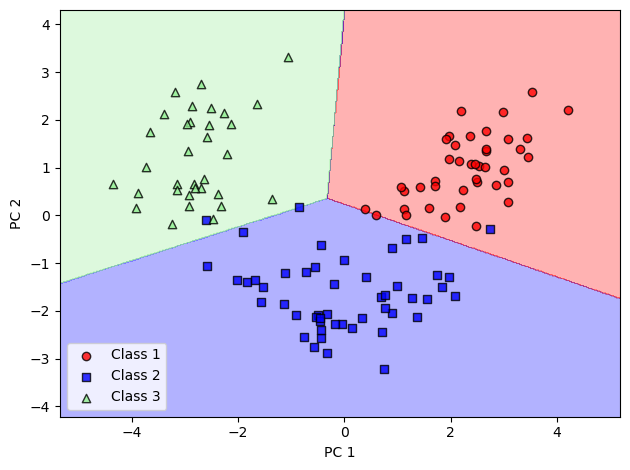

In [26]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)


plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [27]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

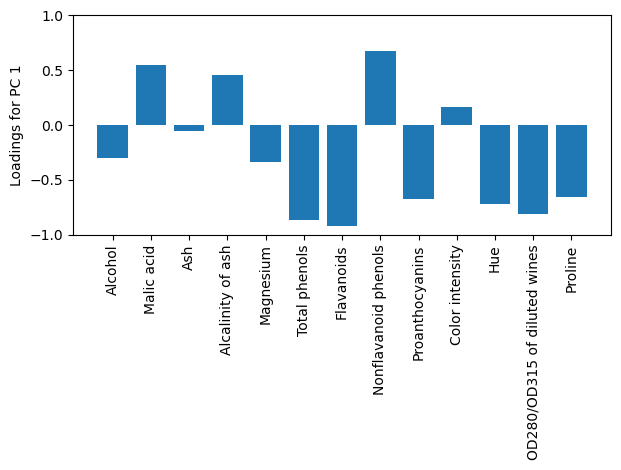

In [29]:
#载荷：原始特征对主成分的贡献作用
#因子载荷为特征向量与特征值平方根的乘积，可以理解为原始特征和主成分之间的相关性
loadings = eigen_vecs * np.sqrt(eigen_vals)
fig, ax = plt.subplots()

ax.bar(range(13), loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [30]:
###LDA 线性判别分析，该方法使用标签，是监督算法，LDA的目标是找到可以提高数据可分性的特征子空间
##LDA步骤
#1.标准化d维数据（d是特征个数） 2.计算每个类别数据的d维均值向量 3.构造类间散布矩阵Sb和类内散布矩阵Sw 4.计算矩阵Sw^-1(Sw的逆矩阵) * Sb的特征值与特征向量
#5.特征向量按照特征值降序的方式进行排列 6.用k个最大特征值对应的特征向量，使用这些特征向量作为变换矩阵的列，构造一个d*x的变换矩阵W
#7.使用投影矩阵W对d维输入数据集X进行变换，获得新的k维特征子空间
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [38]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


In [39]:
print(np.bincount(y_train))

d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: '
      f'{S_W.shape[0]}x{S_W.shape[1]}')

[ 0 41 50 33]
Scaled within-class scatter matrix: 13x13


In [40]:
# Compute the between-class scatter matrix:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # make column vector

d = 13  # number of features
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: '
      f'{S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


In [41]:
#计算矩阵Sw^-1(Sw的逆矩阵) * Sb的广义特征值
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
#计算后对特征值进行降序排序
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.61780890599397
172.76152218979385
8.083700457542382e-14
3.5021010787077537e-14
2.55913878694663e-14
2.55913878694663e-14
1.1800646330824407e-14
9.54558150994035e-15
9.465678066411808e-15
9.465678066411808e-15
5.830160026378068e-15
3.71723684807219e-15
1.788037173519217e-15


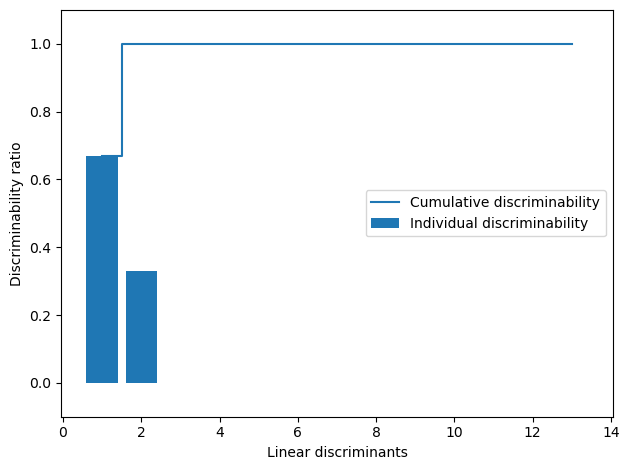

In [42]:
#为了度量线性判别式（特征向量）捕获了多少类判别信息，绘制类似于PCA部分创建的方差比解释图
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, align='center',
        label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [43]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


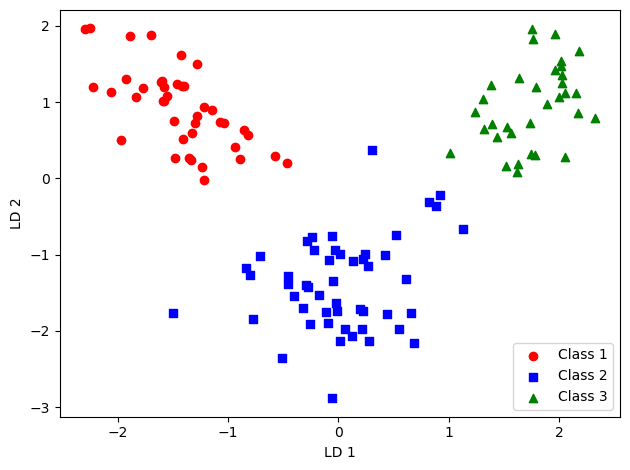

In [45]:
#将样本投影到新的特征空间
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=f'Class {l}', marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [46]:
#使用scikit-learn实现线性判别分析
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

D:\software\Anaconda\envs\pytorchStudy\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


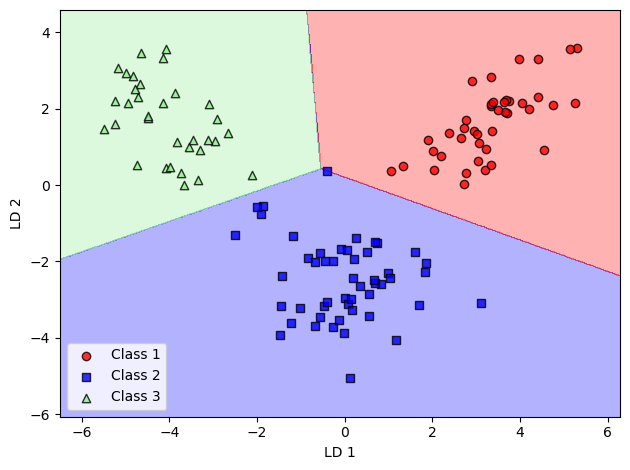

In [47]:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

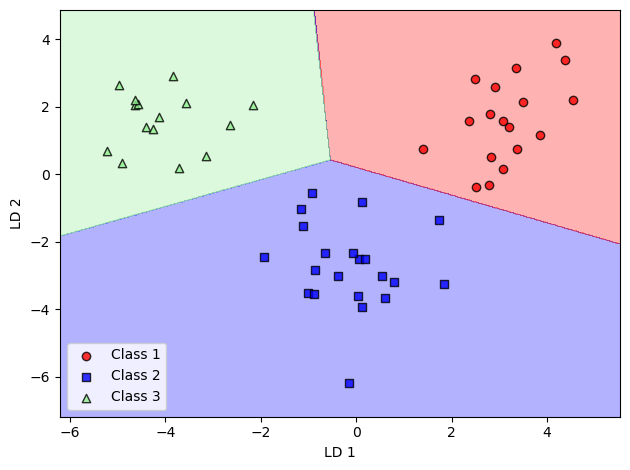

In [49]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

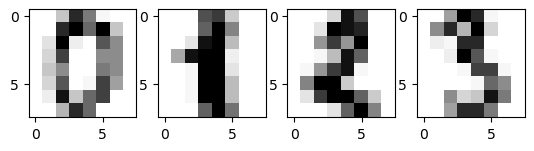

In [50]:
#非线性降维和可视化 t-SNE
digits = load_digits()

fig, ax = plt.subplots(1, 4)

for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys')
    
plt.show() 


In [51]:
digits.data.shape

y_digits = digits.target
X_digits = digits.data

In [52]:
tsne = TSNE(n_components=2,
            init='pca',
            random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

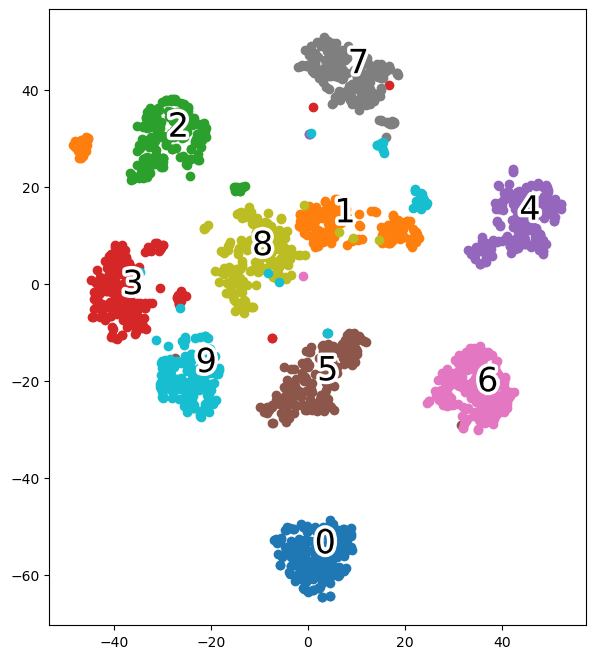

In [53]:
def plot_projection(x, colors):
    
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        plt.scatter(x[colors == i, 0],
                    x[colors == i, 1])

    for i in range(10):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        
plot_projection(X_digits_tsne, y_digits)
plt.show()